# A Continuous Change-Point Model
- categories: [Julia, Turing, Changepoint]

In [1]:
#collapse
using Turing
using Bijectors
using Gadfly
using DataFrames, DataFramesMeta
using StatsPlots
Gadfly.set_default_plot_size(900px, 300px)

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278
┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
└ @ Base loading.jl:1278


In [261]:
τ_true, μ₁, μ₂, σ_true = 500, 45, 30, 4
c = vcat(rand(Normal(μ₁,σ_true), τ_true), 
         rand(Normal(μ₂,σ_true), 1000-τ_true));

std_c = (c .- mean(c)) ./ std(c);

In [198]:
logit = bijector(Beta())   # bijection:  (0, 1)  →  ℝ
inv_logit = inv(logit)     # bijection:       ℝ  →  (0, 1)

function sigm(μ, σ, x)
    return inv_logit(σ*(x - μ))
end;

In [262]:
@model function changepoint(data)
    # priors
    spec = 0.01
    μ_1 ~ Normal(0, 2)
    μ_2 ~ Normal(0, 2)
    τ ~ Uniform(1, 1000)
    σ ~ truncated(Normal(1, 2), 0, 20)
    
    # likelihood
    for i in 1:length(data)
        switch = sigm(τ, spec, i)
        z = (1-switch) * μ_1 + switch * μ_2
        data[i] ~ Normal(z, σ)
    end
end;

In [265]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 2000
ϵ = 0.005
τ = 10;

cp_chain2 = sample(
    changepoint(std_c), 
    HMC(ϵ, τ), iterations, 
    progress=true, drop_warmup=false);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:57


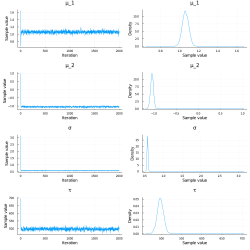

In [266]:
StatsPlots.plot(cp_chain2)

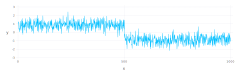

In [271]:
plot(DataFrame(y=std_c, x=1:1000), x=:x, y=:y, Geom.line)